In [1]:
from losses import *
from lr_scheduler import *
from models.ghost.ghost import *
from partial_fc_v2 import *
from dataset import *
from torch.utils.data import DataLoader
import torchvision.transforms as transfroms

# Data Preparation

In [2]:
data_src = '/home/duypham/WorkSpace/Generative_Projects/Face_Recognition/datasets/custom_dataset'

In [3]:
train_image_transforms=transfroms.Compose([
    transfroms.RandomHorizontalFlip(),
    transfroms.ToTensor(),
    transfroms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5)),
])
image_transforms=transfroms.Compose([
    transfroms.ToTensor(),
    transfroms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5)),
])

In [4]:
num_class = 1020

In [5]:
train_set=TrainFaceRegDataset(data_src,train_image_transforms,'train',112)
gallery_set=TrainFaceRegDataset(data_src,image_transforms,'gallery',112)
query_set=TrainFaceRegDataset(data_src,image_transforms,'query',112)

In [6]:
train_loader=DataLoader(train_set,128,shuffle=True)
gallery_loader=DataLoader(gallery_set,128,shuffle=False)
query_loader=DataLoader(query_set,128,shuffle=False)

# Define Model

In [7]:
device= 'cuda' if torch.cuda.is_available() else 'cpu'

backbone = FaceNet(embed_dim=768).to(device)
backbone.load_state_dict(torch.load('./ckpts/2/model_e_119.pt'))
backbone.train()

FaceNet(
  (conv_stem): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): ReLU(inplace=True)
  (blocks): Sequential(
    (0): Sequential(
      (0): GhostBottleneck(
        (ghost1): GhostModule(
          (primary_conv): Sequential(
            (0): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU(inplace=True)
          )
          (cheap_operation): Sequential(
            (0): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=8, bias=False)
            (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU(inplace=True)
          )
        )
        (ghost2): GhostModule(
          (primary_conv): Sequential(
            (0): Conv2d(16, 8, kernel_size=(1, 1),

# Train

In [8]:
epochs =50
total_iters=len(train_loader)*epochs

## loss and scheduler

In [9]:
margin_loss = CombinedMarginLoss(64,1.0, 0.5, 0.00,0)
module_partial_fc = PartialFC_V2(
            margin_loss, 768, num_class,1,True)
module_partial_fc.train().cuda()
optimizer = torch.optim.AdamW(
    params=[{"params": backbone.parameters()}, {"params": module_partial_fc.parameters()}],
    lr=1e-4, weight_decay=0.1)
total_iters=len(train_loader)*epochs
lr_scheduler = PolynomialLRWarmup(
        optimizer=optimizer,
        warmup_iters=total_iters//10,
        total_iters=total_iters)

In [10]:
from utils.load_model import *


In [11]:
from tqdm import tqdm
from accelerate import Accelerator
from eval import eval_model
def train_loop(epochs, model,module_partial_fc, optimizer, train_dataloader,gallery_loader,query_loader, lr_scheduler,device='cuda',ckpt_path='./ckpts'):
    # Initialize accelerator and tensorboard logging
    model.to(device)
    module_partial_fc.to(device)
    accelerator = Accelerator(
        mixed_precision='fp16',
        gradient_accumulation_steps=1,
    )
    model,module_partial_fc, optimizer, train_dataloader, lr_scheduler = accelerator.prepare(
        model,module_partial_fc, optimizer, train_dataloader, lr_scheduler
    )

    global_steps=0
    # Now you train the model
    for epoch in range(epochs):
        progress_bar = tqdm(total=len(train_dataloader))
        progress_bar.set_description(f"Epoch {epoch}")

        module_partial_fc.train()
        model.train()
        for step, (image,label) in enumerate(train_dataloader):
            global_steps+=1
            image = image.to(device)
            label=label.to(device)

            with accelerator.accumulate(model):
                img_emb = model(image)
                loss = module_partial_fc(img_emb, label)
                accelerator.backward(loss)
                if accelerator.sync_gradients:
                    accelerator.clip_grad_norm_(model.parameters(), 1.0)
                optimizer.step()
                lr_scheduler.step()
                optimizer.zero_grad()
            progress_bar.update(1)
            logs = {"loss": loss.detach().item(), "lr": lr_scheduler.get_last_lr()[0], "step": global_steps}
            progress_bar.set_postfix(**logs)
        if epoch%50==0:
            unwarp_model=accelerator.unwrap_model(model)
            eval_board=eval_model(unwarp_model,gallery_loader,query_loader,device)
            print(eval_board)
            os.makedirs(ckpt_path,exist_ok=True)
            torch.save(unwarp_model.state_dict(), os.path.join(ckpt_path,'model_e_{epoch}.pt'))
            print('==>Save<==')


/home/duypham/miniconda3/envs/face-env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
from accelerate import notebook_launcher

args = (epochs, backbone,module_partial_fc, optimizer, train_loader,gallery_loader,query_loader, lr_scheduler,'cuda','./ckpts')

notebook_launcher(train_loop, args, num_processes=1)

Launching training on one GPU.


TypeError: train_loop() missing 1 required positional argument: 'lr_scheduler'

In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
import torch
import torch.nn.functional as F
import os
def visualize_tsne(model,train_loader, perplexity=5,device='cuda',save_path='./visualize_training',e=0):
    print('Saving png file...')
    os.makedirs(save_path,exist_ok=True)
    new_save_path=os.path.join(save_path,str(len(os.listdir(save_path))))
    os.makedirs(new_save_path,exist_ok=True)
    embeddings=[]
    labels=[]
    model.to(device)
    for image,label in train_loader:
        model.eval()
        with torch.inference_mode():
            image = image.to(device)
            label=label.to(device)

            embedding= model(image)
            embeddings.extend(F.normalize(embedding.detach().cpu(),dim=-1).numpy().tolist())
            labels.extend(label.detach().cpu().numpy().tolist())
            if len(embeddings)>200:
                break
    X = np.array(embeddings)
    y = np.array(labels)
    # t-SNE
    tsne = TSNE(n_components=2, perplexity=perplexity, learning_rate='auto')
    X_tsne = tsne.fit_transform(X)

    # Normalize to unit circle
    norms = np.linalg.norm(X_tsne, ord=2, axis=1, keepdims=True)
    X_tsne = X_tsne / norms

    # Convert to DataFrame
    df = pd.DataFrame({
        "x": X_tsne[:, 0],
        "y": X_tsne[:, 1],
        "label": y
    })

    # Plot with seaborn
    plt.figure(figsize=(8, 8))
    sns.scatterplot(
        data=df,
        x="x", y="y",
        hue="label",
        palette="tab20",
        s=10, alpha=0.7,
        linewidth=0,
        legend=False
    )
    plt.title("t-SNE visualization of embeddings")
    # plt.savefig(os.path.join(new_save_path,f"tsne_plot_{e}.png"), dpi=300, bbox_inches="tight")
    plt.show()


In [14]:
eval_model(backbone,gallery_loader,query_loader)

Running Eval:  97%|█████████▋| 4686/4813 [00:47<00:01, 99.34it/s, time=47.17s]


{'Top-1-Precision': 0.9984170198440552,
 'Top-5-Precision': 0.9982361197471619,
 'Top-10-Precision': 0.9991409182548523,
 'Top-20-Precision': 0.9995585083961487,
 'mAP': 0.9999935868428363}

In [13]:
from eval import eval_model

Saving png file...


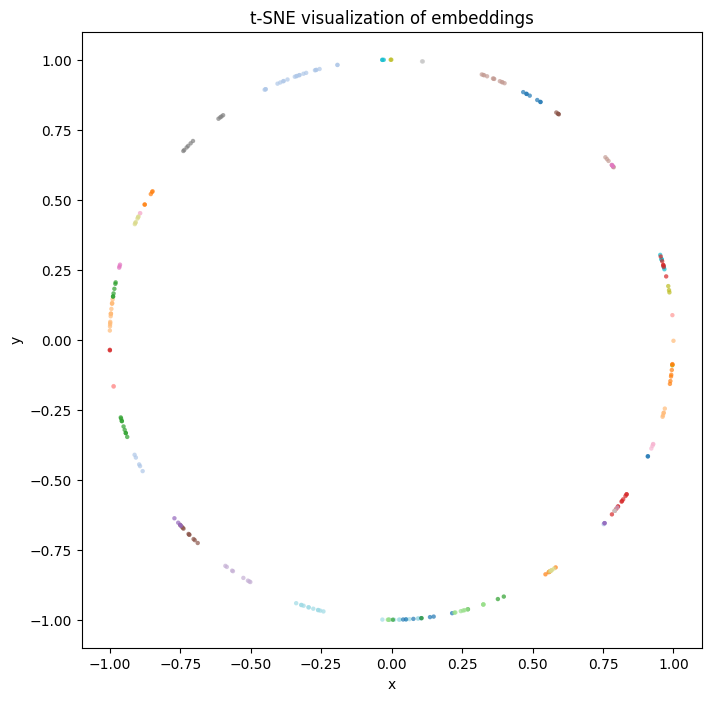

In [33]:
visualize_tsne(backbone,gallery_loader,25)

In [ ]:
import cv2
import numpy as np
from facenet_pytorch import MTCNN
from PIL import Image
import concurrent.futures
# Hàm alignment
def align_face(img, src_landmarks, dst_landmarks, size=(112, 112)):
    # Tính ma trận affine từ landmark thực tế sang landmark chuẩn
    M, _ = cv2.estimateAffinePartial2D(np.array(src_landmarks), dst_landmarks)
    aligned = cv2.warpAffine(img, M, size)
    return aligned


# Template landmark chuẩn cho ArcFace (112x112)


def process(path):
    img = cv2.resize(cv2.imread(path),(112,112),interpolation=cv2.INTER_AREA)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    arcface_template = np.array([
        [38.2946, 51.6963],   # mắt trái
        [73.5318, 51.5014],   # mắt phải
        [56.0252, 71.7366],   # mũi
        [41.5493, 92.3655],   # miệng trái
        [70.7299, 92.2041]    # miệng phải
    ], dtype=np.float32)
    # 2. Dùng MTCNN detect
    mtcnn = MTCNN(keep_all=True)
    boxes, probs, landmarks = mtcnn.detect(Image.fromarray(img_rgb), landmarks=True)
    if landmarks is not None:
        # for lm in landmarks:   # lm có shape (5,2): mắt trái, mắt phải, mũi, miệng trái, miệng phải
        src_landmarks = np.array(landmarks[0], dtype=np.float32)

        # 3. Alignment
        img_rgb = align_face(img_rgb, src_landmarks, arcface_template, size=(112,112))

        # 4. Lưu ảnh đã căn chỉnh
        cv2.imwrite(path, cv2.cvtColor(img_rgb, cv2.COLOR_RGB2BGR))
with concurrent.futures.ProcessPoolExecutor(max_workers=16) as E:
    E.map(process,glob.glob('/home/duypham/WorkSpace/Generative_Projects/Face_Recognition/datasets/custom_dataset/*/*.png'))

